# Quantum Chemistry VQE

In [18]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

In [19]:
H = SparsePauliOp(['XX', 'YY', 'ZZ'], coeffs=[1.+0.j, 1.+0.j, 1.+0.j])  # goal of Hamiltonian structure

In [20]:
import matplotlib.pyplot as plt
import numpy as np
!pip install pyscf==2.4.0
from pyscf import ao2mo, gto, mcscf, scf

H2 molecule

In [21]:
distance = 0.735
a=distance/2
mol = gto.Mole()
mol.build(
        verbose=0,
        atom=[
            ["H", (0, 0, -a)],
            ["H", (0, 0, a)],
        ],
        basis="sto-6g",
        spin=0,
        charge=0,
        symmetry="Dooh",
    )

In [22]:
print(mol.energy_nuc(),
      mol.energy_elec()[0],
      mol.energy_tot(),
      mol.energy_tot() - mol.energy_nuc()
      )

0.7199689944489797 -1.8455976628764188 -1.125628668427439 -1.8455976628764188


# VQE IBM qiskit tutorial

## 1: Generate Hamiltonian and ansatz

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

In [24]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)

Ansatz = EfficientSU2 - by default linearly entangles qubits

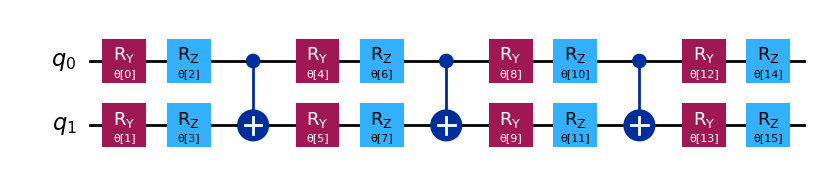

In [25]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)  #arbitrary hamiltonian - observables

ansatz = EfficientSU2(hamiltonian.num_qubits) # randomized angles for RY-RZ-CX pattern
ansatz.decompose().draw("mpl")

## 2: Optimize for execution on specific backend

Qiskit primitives only accept quantum circuit (ansatz) and Hamiltonian (observables) compatible with QPU of interest. These connectivities and instructions prepare  circuits and observables known as the instruction set architecture (ISA).

In [26]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

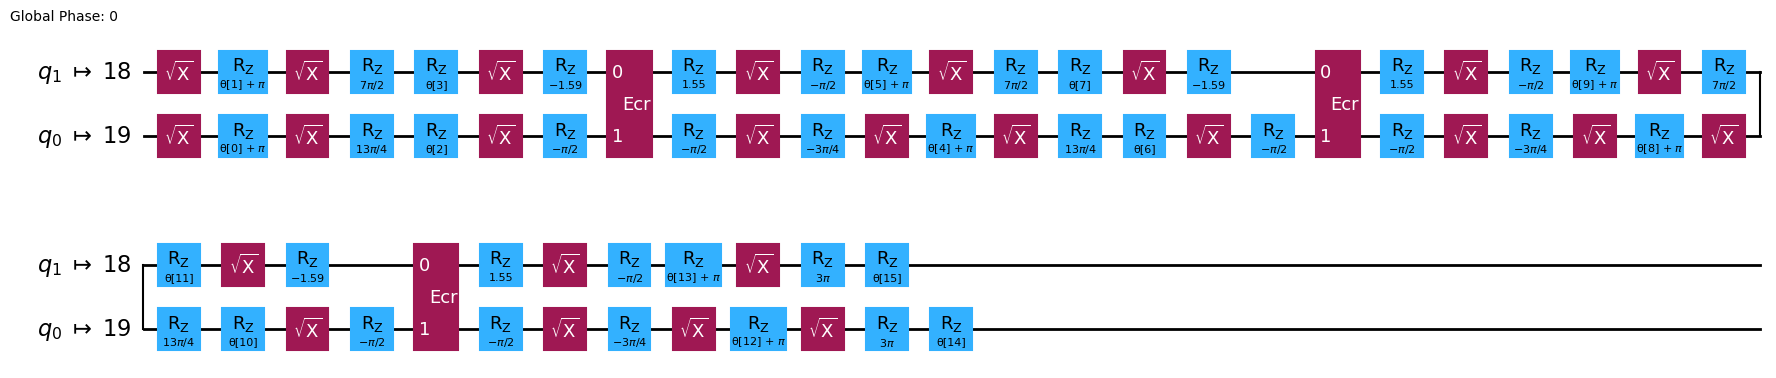

In [27]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [28]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## 3: Execute with Qiskit Primitives

In [29]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])   # primitive unified bloc (format: circuit, observables, parameters)
    result = estimator.run(pubs=[pub]).result()  # input pub into estimator
    energy = result[0].data.evs[0]  # energy estimate

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [30]:
# store current parameter vector, number of iterations, average time per iteration at each iteration in a dictionary

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [31]:
# specify random set of initial parameters for ansatz

num_params = ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

In [32]:
x0

array([3.02378033, 2.4780037 , 0.0955278 , 3.30205884, 0.23618031,
       2.80836215, 1.31898952, 0.84930011, 1.88347691, 0.67330878,
       1.49062985, 3.33349399, 6.02246682, 3.02536661, 3.01733603,
       2.31018884])

In [33]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",  # using cobyla routine from scipy
    )

IBMRuntimeError: 'Failed to run program: \'403 Client Error: Forbidden for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"message":"Job create exceeds open plan job usage limits","code":4317,"solution":"Please wait until the beginning of next month to submit more jobs when your quota will reset.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''